In [ ]:
!pip install gensim textblob

In [ ]:
import pandas as pd
import nltk
import gensim
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv("hf://datasets/stephaniestv/Electronics_Product_Review_With_Sentiment/Amazon_Electronics_Review.csv")

In [ ]:
#pre-processing reviews
def tokenize_text(text):
    text = str(text).lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens
                  if token.isalpha() and token not in stop_words]
    return lemmatized

def join_tokens(text):
    return ' '.join(text)

#lexicon based sentiment analysis
def sentiment_analysis(df,col_name):
    df_textblob = pd.DataFrame()
    df_vader = pd.DataFrame()

    df_textblob['index'] = df['index']  # Retain original index
    df_vader['index'] = df['index']

    # TextBlob sentiment
    df_textblob['sentiment_score'] = df[col_name].apply(lambda x: TextBlob(x).sentiment.polarity)
    df_textblob['sentiment_label'] = df_textblob['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.4 else 'negative' if x < -0.4 else 'neutral')

    # VADER sentiment
    df_vader['sentiment_score'] = df[col_name].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df_vader['sentiment_label'] = df_vader['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.04 else 'negative' if x < -0.04 else 'neutral')

    # Merge on original index and sentiment_label
    merged_df = pd.merge(df_textblob, df_vader, on=['index', 'sentiment_label'], how='inner')
    merged_df = merged_df.set_index('index')  # Restore original index

    # Filter original df based on index
    filtered_df = df.set_index('index').loc[merged_df.index].copy()
    filtered_df['sentiment_label'] = merged_df['sentiment_label']
    filtered_df['TB_SCORE'] = merged_df['sentiment_score_x']
    filtered_df['VADER_SCORE'] = merged_df['sentiment_score_y']

    return filtered_df


In [ ]:
count_by_asin = df.groupby('asin').size().reset_index(name='count').sort_values(by=['count'],ascending=False)
print(count_by_asin)
sub_df = df[df['asin'] == 'B01G8JO5F2'].copy()
sub_df = sub_df.reset_index(drop=False)  # Keep old index for tracking
sub_df.head(9)
abc=sentiment_analysis(sub_df,'text')
abc.to_csv('d2.csv')

             asin  count
21204  B01G8JO5F2   1373
14489  B00ZV9RDKK    472
19863  B01DFKC2SO    316
15993  B014YN7LVE    227
33600  B079QHML21    223
...           ...    ...
26638  B06XDKD482      1
26639  B06XDKDGV5      1
26640  B06XDKVZMF      1
26642  B06XDLT17K      1
69392  B0BXX8RRK2      1

[69393 rows x 2 columns]


In [ ]:
from itertools import count
#aspect based sentiment analysis
def aspect_sentiment_analysis(df, aspects, col_name):
    results = []

    for aspect in aspects:
        # Find reviews mentioning the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if len(aspect_reviews) > 0:
            # Calculate sentiment for these reviews
            output= sentiment_analysis(aspect_reviews,col_name)
            sentiments = output['sentiment_label']
            pred_txb = output['TB_SCORE']
            pred_vader = output['VADER_SCORE']

            # Map sentiment labels to numeric scores
            sentiment_numeric = sentiments.map({'positive': 1, 'neutral': 0, 'negative': -1})

            # Aggregate results
            stats = {
                'aspect': aspect,
                'mention_count': len(aspect_reviews),
                'avg_act_sentiment': sentiment_numeric.mean()*100,
                'positive_pct': (sentiments == 'positive').mean() * 100,
                'negative_pct': (sentiments == 'negative').mean() * 100,
                'neutral_pct': (sentiments == 'neutral').mean() * 100
            }
            results.append(stats)

    aspect_results=pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='aspect', y='avg_act_sentiment', data=aspect_results.sort_values('avg_act_sentiment'))
    return print(aspect_results)

In [ ]:
# n-gram analysis
def n_gram(df,col_name,n_token,words_to_remove):
  df_ngram=pd.DataFrame()
  df_ngram['processed_text'] = df[col_name].apply(tokenize_text).apply(join_tokens)

  stop_words = set(stopwords.words('english')).union(set(words_to_remove))

  vectorizer = CountVectorizer(
    stop_words=list(stop_words) ,
    token_pattern=r'(?u)\b\w\w+\b',
    ngram_range=(n_token,n_token),
    max_df=0.7,
    min_df=1
  )
  X = vectorizer.fit_transform(df_ngram['processed_text'])

  ngrams = vectorizer.get_feature_names_out()
  ngrams_freq = pd.DataFrame(X.toarray(), columns=ngrams).sum().sort_values(ascending=False)
  top_ngrams = ngrams_freq.head(20)

  # Post-processing to filter similar n-grams
  unique_ngrams = []
  seen_lemmas = set()

  for ngrams in top_ngrams.index:
      # Get unique lemmas
      ngrams_lemmas = frozenset([lemmatizer.lemmatize(word) for word in ngrams.split()])

      # Only keep if we haven't seen this combination before
      if ngrams_lemmas not in seen_lemmas:
          unique_ngrams.append(ngrams)
          seen_lemmas.add(ngrams_lemmas)
      if len(unique_ngrams) >= 10:
          break

  final_ngrams = top_ngrams[unique_ngrams]

  # Visualization
  plt.figure(figsize=(12, 8))
  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')
  plt.xlabel("Frequency")
  return print(final_ngrams)


In [ ]:
#aspect based clustering
def clustering_review(df,col_name,n_clusters,aspects):
  aspect_sentences = {}
  for aspect in aspects:
    subset = df[df[col_name].str.contains(aspect, case=False, na=False)]
    aspect_sentences[aspect] = [tokenize_text(text) for text in subset[col_name]]


  for aspect, sentences in aspect_sentences.items():
    print(f"\n=== Aspect: {aspect} ===")
    if len(sentences) < 1:
        print("Not enough data.")
        continue

    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

    words = list(model.wv.index_to_key)
    vectors = np.array([model.wv[word] for word in words])

    if len(words) < 5:
        print("Not enough unique words to cluster.")
        continue

    n = min(n_clusters, len(words))  # avoid asking for more clusters than words
    kmeans = KMeans(n_clusters=n, random_state=0)
    clusters = kmeans.fit_predict(vectors)
    centroids = kmeans.cluster_centers_

    word_df = pd.DataFrame(vectors, index=words)
    word_df['cluster'] = clusters

    top_words = {}
    for i in range(n_clusters):
        cluster_words = word_df[word_df['cluster'] == i].drop('cluster', axis=1)
        dists = np.linalg.norm(cluster_words.values - centroids[i], axis=1)
        closest_indices = dists.argsort()[:5]
        top_words[i] = cluster_words.iloc[closest_indices].index.tolist()

    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}: {words}")


In [ ]:
def generate_aspect_wordclouds(df, aspects, col_name):
    for aspect in aspects:
        # Filter reviews containing the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if not aspect_reviews.empty:
            # Apply tokenize_text to each review, then flatten the list of tokens
            all_tokens = []
            for review in aspect_reviews[col_name].dropna().astype(str):
                tokens = tokenize_text(review)
                all_tokens.extend(tokens)

            # Join tokens into a single string
            text = " ".join(all_tokens)

            # Generate word cloud
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

            # Display
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud for Aspect: '{aspect}'", fontsize=16)
            plt.show()


In [ ]:
indv_sent= sentiment_analysis(sub_df,'text')

pos_df= indv_sent[indv_sent['sentiment_label']=='positive']
neg_df= indv_sent[indv_sent['sentiment_label']=='negative']
neu_df= indv_sent[indv_sent['sentiment_label']=='neutral']
pos_df

,rating,title,text,asin,user_id,timestamp,helpful_vote,verified_purchase,sentiment,sentiment_label,TB_SCORE,VADER_SCORE
index,,,,,,,,,,,,
8234,5,Works great with multiple ear piercings,I am so happy with these!! I have a lot of ear...,B01G8JO5F2,AEJ33R64CS46LK4ZN3RHTLTBO4ZQ,3/3/2018,1,True,1,positive,0.540000,0.8386
34550,5,"Great sound. Easy to use, very comfortable lig...",Good quality headphones. Very good sound and b...,B01G8JO5F2,AGOL5R2RPTK4SYEFSILKAPTXB5LA,7/21/2017,0,True,1,positive,0.484667,0.8514
47742,3,Sounds good. Very easy to program,Sounds good. Very easy to program. Not as lo...,B01G8JO5F2,AHQVC5ZUMGV5CLH4GUI2TZRUSLUA,5/9/2018,0,True,1,positive,0.621111,0.6055
49465,4,Great for the price,Great for the price. Always works well. Fit gr...,B01G8JO5F2,AGZQNUB3JH43FBJ2IJ7RG4J3QZUQ,1/16/2023,0,True,1,positive,0.666667,0.9153
49483,4,Great but a little to big,"Really nice great sound great microphone, ever...",B01G8JO5F2,AFLC7IPEZCXLWJOC65LVTQZCIJNQ,12/14/2018,0,True,1,positive,0.533333,0.8879
...,...,...,...,...,...,...,...,...,...,...,...,...
53208,4,No complaints thus far,"Great sound, battery life & price.",B01G8JO5F2,AFX4WPYXBGAPINF2ROKUF6MWL27A,1/5/2019,0,True,1,positive,0.600000,0.6249
57980,4,Four Stars,nice product... good sound and battery,B01G8JO5F2,AGSJ3TZWBR3R6MXARZAARTDWAL7A,6/8/2018,0,True,1,positive,0.566667,0.6908
58707,4,Easy to set up.,Great sound and easy to connect.,B01G8JO5F2,AH3QTZWCWMCGQJYC5JLCMTRJOKDA,1/25/2017,0,True,1,positive,0.544444,0.7906


/tmp/ipython-input-1161970434.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


sound quality       19
battery life        17
sound battery        5
customer service     5
quality battery      5
fit sound            4
sound price          4
two pair             4
price point          3
low price            3
dtype: int64


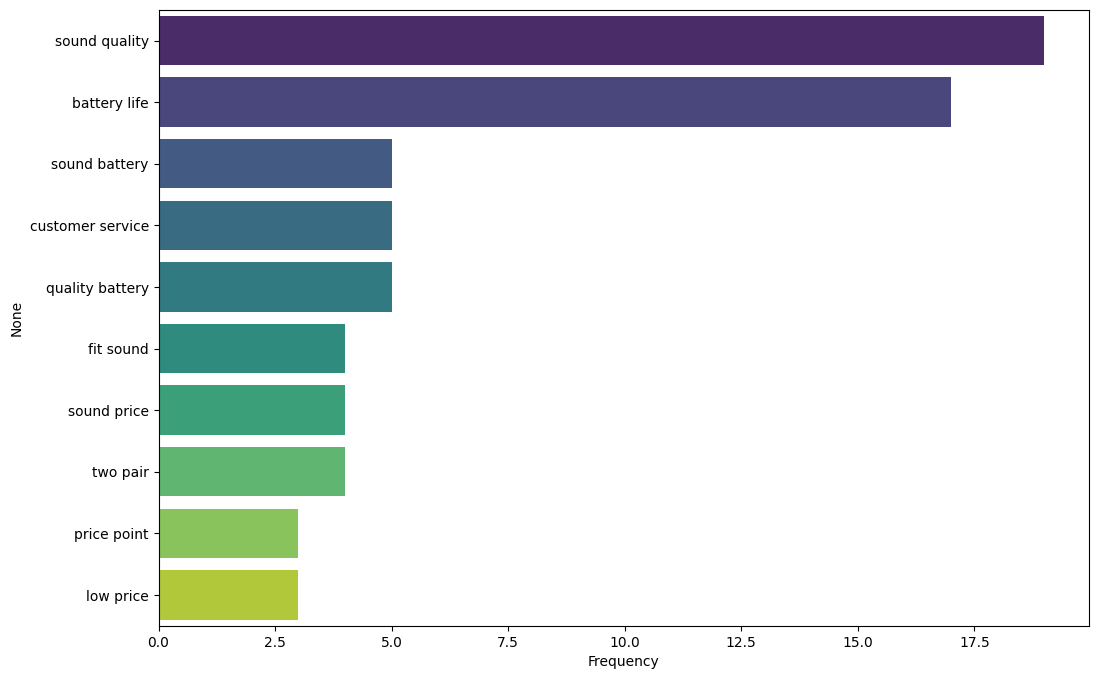

In [ ]:
pos_words=n_gram(pos_df,'text',2,['buy','good','great','one','happy','work','well','give','star','bud','ear','head','phone','easy',
                                  'headphone','excellent','recommend','worked'])
pos_words

/tmp/ipython-input-1161970434.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


stopped working    5
phone pocket       2
phone call         2
less month         2
battery life       2
place part         1
plastic shell      1
play song          1
pocket battery     1
reception weak     1
dtype: int64


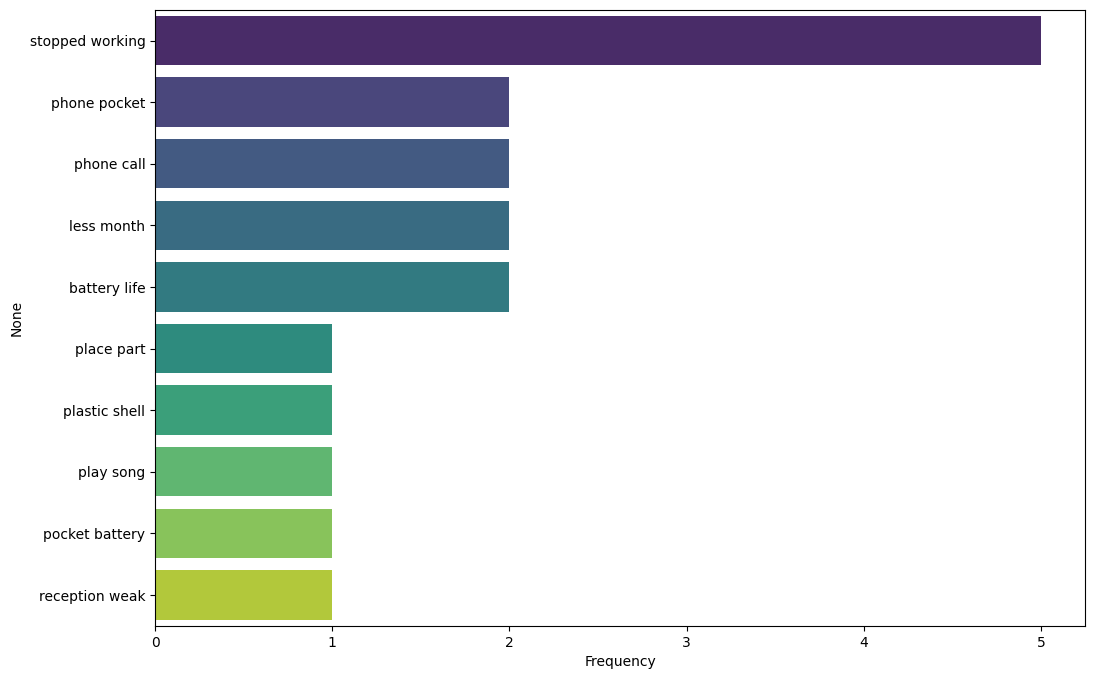

In [ ]:
neg_words=n_gram(neg_df,'text',2,['headphone','terrible','worst','bad','product','even','work','also','really'])
neg_words

/tmp/ipython-input-1161970434.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


battery life      4
last long         3
return window     3
full charge       3
last month        3
charge anymore    2
lasted month      2
ear hook          2
wo charge         2
window closed     2
dtype: int64


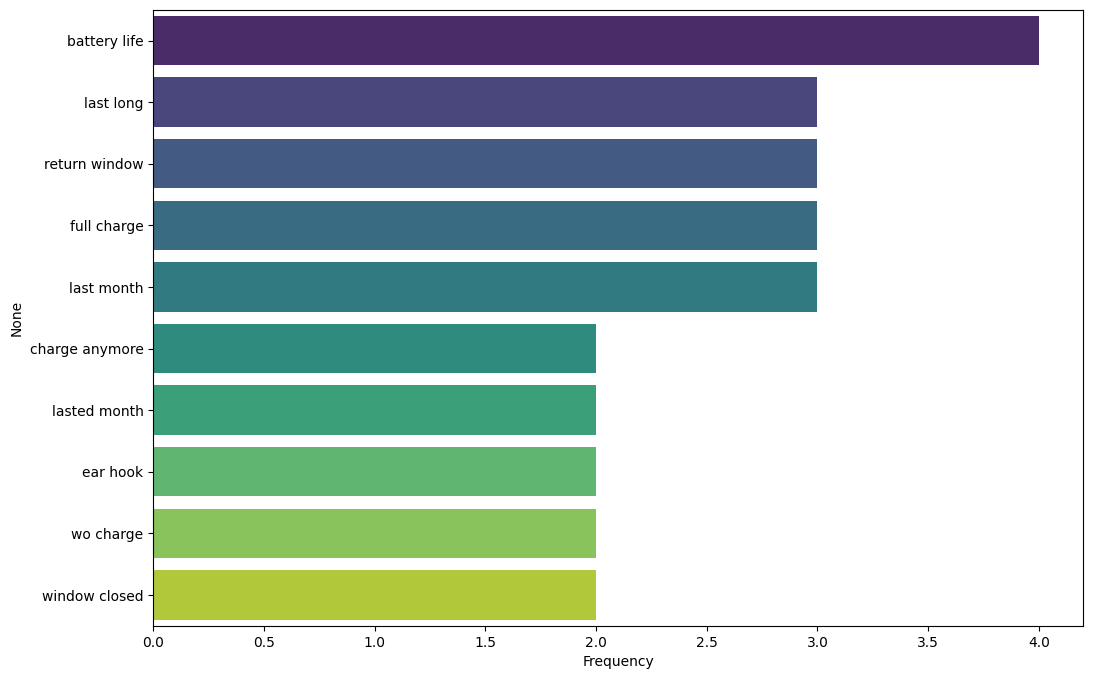

In [ ]:
neu_words=n_gram(neu_df,'text',2,['could'])
neu_words

    aspect  mention_count  avg_act_sentiment  positive_pct  negative_pct  \
0   charge            221          17.142857     37.142857     20.000000   
1  battery            173          65.625000     71.875000      6.250000   
2     call             74          11.111111     44.444444     33.333333   
3    sound            480          85.227273     87.500000      2.272727   

   neutral_pct  
0    42.857143  
1    21.875000  
2    22.222222  
3    10.227273  


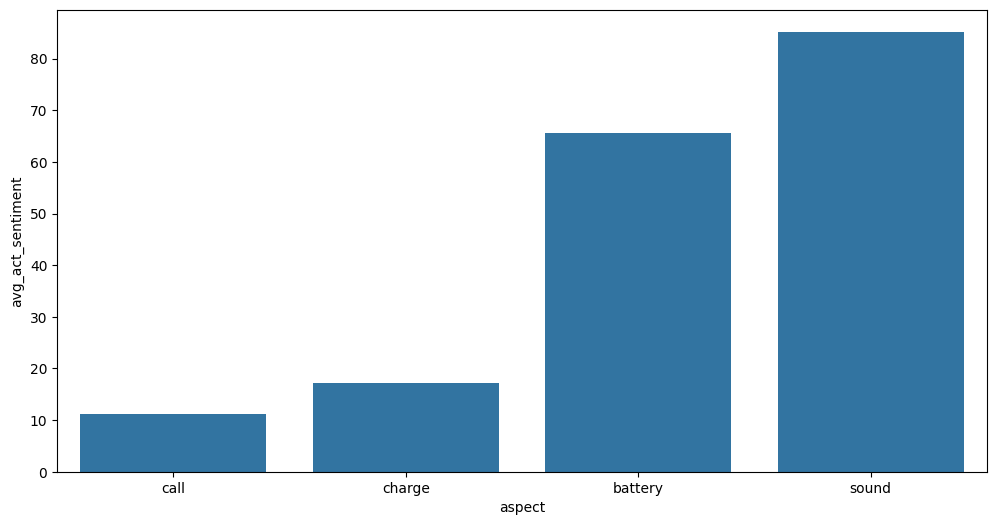

In [ ]:
aspect_sentiment_analysis(sub_df, ['charge','battery','call','sound'], 'text')

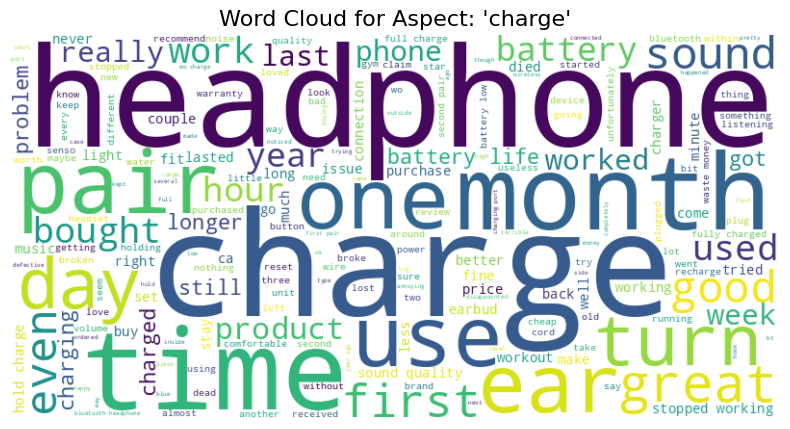

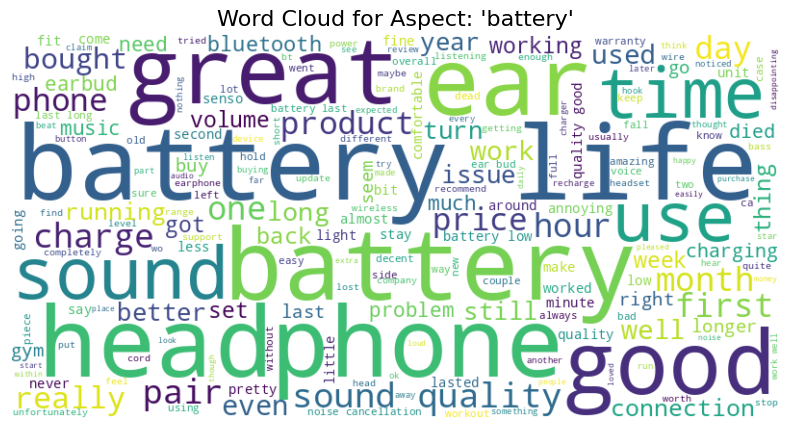

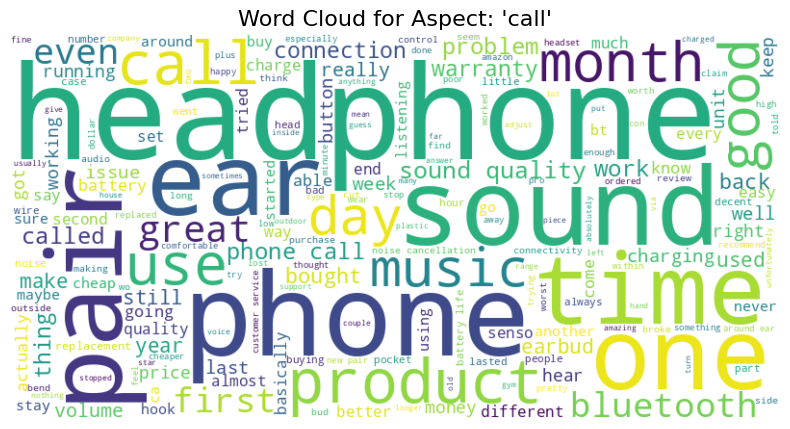

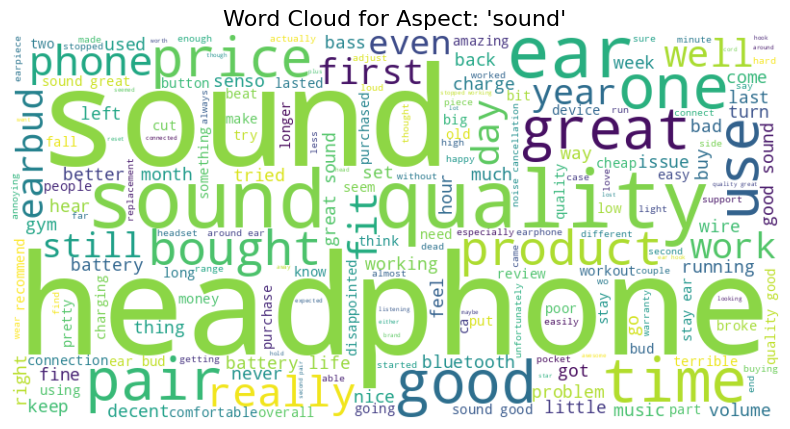

In [ ]:

generate_aspect_wordclouds(sub_df, ['charge','battery','call','sound'], 'text')

In [ ]:
cluster= clustering_review(sub_df, 'text',3,['charge','battery','call','sound'])


=== Aspect: charge ===
Cluster 0: ['skeptic', 'sitting', 'swapped', 'developed', 'receives']
Cluster 1: ['claim', 'plugged', 'getting', 'water', 'cable']
Cluster 2: ['multiple', 'recharged', 'deal', 'audio', 'october']

=== Aspect: battery ===
Cluster 0: ['known', 'outlet', 'heating', 'cover', 'pouch']
Cluster 1: ['power', 'set', 'fine', 'seems', 'dead']
Cluster 2: ['suddenly', 'hair', 'purchase', 'mind', 'audible']

=== Aspect: call ===
Cluster 0: ['regard', 'follow', 'chase', 'cheapest', 'false']
Cluster 1: ['going', 'last', 'hear', 'come', 'day']
Cluster 2: ['inside', 'charged', 'gym', 'amazing', 'voice']

=== Aspect: sound ===
Cluster 0: ['world', 'closing', 'filed', 'vent', 'durablity']
Cluster 1: ['wearing', 'pleased', 'worth', 'quickly', 'next']
Cluster 2: ['samsung', 'giving', 'whether', 'terrific', 'accurate']


In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def analyze_reviews(df, text_column, aspects):
    """
    Find most relevant words around your aspects WITHOUT clustering

    Args:
        df: Your DataFrame
        text_column: Name of text column
        aspects: List of focus words (e.g., ['price', 'quality'])

    Returns:
        Dictionary of {aspect: [top 10 related words]}
    """
    results = {}
    stop_words = set(stopwords.words('english'))

    for aspect in aspects:
        aspect_words = []

        for text in df[text_column].dropna().str.lower():
            words = nltk.word_tokenize(text)

            if aspect in words:
                idx = words.index(aspect)
                start = max(0, idx-5)  # 3 words before
                end = min(len(words), idx+4)  # 3 words after
                context = words[start:end]

                # Filter out junk
                clean_words = [
                    w for w in context
                    if w not in stop_words
                    and w.isalpha()
                    and w != aspect
                ]
                aspect_words.extend(clean_words)

        # Get most common words
        top_words = [word for word, count in Counter(aspect_words).most_common(10)]
        results[aspect] = top_words

    return results

# Usage:
aspects = ['charge','battery','call','sound']
word_groups = analyze_reviews(sub_df, 'text', aspects)
word_groups

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'charge': ['would',
  'hold',
  'longer',
  'turn',
  'full',
  'wo',
  'even',
  'stopped',
  'battery',
  'one'],
 'battery': ['life',
  'sound',
  'good',
  'quality',
  'great',
  'low',
  'long',
  'last',
  'lasts',
  'use'],
 'call': ['phone',
  'answer',
  'making',
  'like',
  'volume',
  'switch',
  'incoming',
  'definitely',
  'recommend',
  'running'],
 'sound': ['quality',
  'good',
  'great',
  'br',
  'headphones',
  'decent',
  'battery',
  'fit',
  'price',
  'fine']}